In [1]:
!pip install numpy==1.24.2 
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 24.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-qw32xjj6
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-qw32

In [2]:
import os, sys 
import gymnasium as gym
import time
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import text_flappy_bird_gym
import numpy as np

I tried runnning this without any agent, we can see that it's based on randomness if the flappy bird flaps or stays idle, so we end up with a score of 0.

In [3]:
if __name__ == '__main__':

    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    obs = env.reset()

    # iterate
    while True:

        # Select next action
        action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)

        # Render the game
        os.system("clear")
        sys.stdout.write(env.render())
        time.sleep(0.2) # FPS

        # If player is dead break
        if done:
            break

    env.close()

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @           | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=-3)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[      @             ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=11,dy=-1)
Text Flappy Bird!
Score: 0
----------------------
[     

# **Q-Learning Agent**

A Q-learning agent is a type of reinforcement learning agent that uses a technique called Q-learning to learn an optimal policy for an environment. In reinforcement learning in general, an agent interacts with an environment by taking actions and receiving rewards. The goal of the agent is to learn a policy that maximizes its expected cumulative reward over time.

In Q-learning, the agent learns an action-value function Q(s,a), which gives the expected cumulative reward for taking action a in state s and following the optimal policy thereafter. The agent updates its estimate of Q(s,a) based on the rewards it receives and the estimates of Q(s',a') for the next state s' and all possible actions a'. The update rule is given by:

Q(s,a) <- Q(s,a) + alpha * (r + gamma * max(Q(s',a')) - Q(s,a))

where r is the reward received for taking action a in state s, alpha is the learning rate, gamma is the discount factor, and max(Q(s',a')) is the maximum expected cumulative reward over all possible actions a' in the next state s'.

By repeatedly updating its estimate of Q(s,a) over many episodes of interaction with the environment, the Q-learning agent learns an optimal policy that maximizes the expected cumulative reward. The agent selects actions based on its estimate of the action-value function, choosing the action with the highest expected cumulative reward in the current state.

## Class of the Agent

The QLearningAgent class is an implementation of a Q-learning agent, which learns to make decisions in an environment based on rewards received for its actions. The agent initializes with hyperparameters such as the number of actions and states available, the exploration rate, and discount factor, and updates its action-value estimates through the agent_step method, which is based on the Q-learning algorithm. The agent uses epsilon-greedy exploration to balance exploration and exploitation and updates its Q-values based on the reward received and the Q-value of the current state. The agent also has a test_step method for testing in a given environment, where it always chooses the action with the highest Q-value for the given state.

In [3]:
class QLearningAgent():

    def __init__(self, number_actions = 2, number_states = 308, eps_start=1.0, eps_decay=.9999, eps_min=1e-08, step_size=0.1, discount=1):
        """
        Initializes the agent with the specified hyperparameters.
        
        Args:
            number_actions (int): the number of actions available to the agent
            number_states (int): the number of possible states in the environment
            eps_start (float): the starting value of the exploration rate
            eps_decay (float): the rate at which the exploration rate decays over time
            eps_min (float): the minimum value that the exploration rate can take
            step_size (float): the step size to use for updating the action-value estimates
            discount (float): the discount factor to use for future rewards
        """
        self.number_actions = number_actions
        self.number_states = number_states
        self.epsilon = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.step_size = step_size
        self.discount = discount
        self.rand_generator = np.random.RandomState(1)
        
        # Initialize the array of action-value estimates to zero.
        self.state_dict = {}
        self.q = np.zeros((self.number_states, self.number_actions))

    
    def agent_start(self, state):
        """
        Selects the first action for the agent at the beginning of each episode.
        
        Args:
            state (tuple): the initial state of the environment
        Returns:
            action (int): the action to take in the current state
        """
        # Update the exploration rate at the start of each episode
        self.epsilon = max(self.epsilon * self.eps_decay, self.eps_min)

        # If the state is new, add it to the state dictionary and assign an index to it
        if state not in self.state_dict.keys():
            self.state_dict[state] = len(self.state_dict)
        state_idx = self.state_dict[state]

        # Choose the action to take using epsilon-greedy exploration
        current_q = self.q[state_idx,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.number_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection

        # Update the previous state and action for use in the next step
        self.prev_state_idx = self.state_dict[state]
        self.prev_action = action

        return action
    

    def agent_step(self, reward, state):
        """
        Updates the agent's action-value estimates based on the reward received for the previous action.
        Then selects the next action to take in the current state.
        
        Args:
            reward (float): the reward received for the previous action
            state (tuple): the current state of the environment
        Returns:
            action (int): the action to take in the current state
        """
        # If the state is new, add it to the state dictionary and assign an index to it
        if state not in self.state_dict.keys():
            self.state_dict[state] = len(self.state_dict)
        state_idx = self.state_dict[state]

        # Choose the action to take using epsilon-greedy exploration
        current_q = self.q[state_idx, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.number_actions)
        else:
            action = self.argmax(current_q)

        # Perform an update
        self.q[self.prev_state_idx][self.prev_action] = (1-self.step_size) * self.q[self.prev_state_idx][self.prev_action] + \
                                                     self.step_size * (reward + self.discount * self.q[state_idx][self.argmax(current_q)])
        
        # Update history
        self.prev_state_idx = self.state_dict[state]
        self.prev_action = action

        return action
        
    def agent_end(self, reward):
        """This method is called when the agent reaches the end of an episode.
        It updates the Q-value of the last action taken by the agent in the previous
        state, using the reward received and the Q-value of the current state.
        
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last Q-value update (terminal state value is always 0, so we can ignore it)
        self.q[self.prev_state_idx][self.prev_action] = (1-self.step_size) * self.q[self.prev_state_idx][self.prev_action] + \
                                                        self.step_size * reward
    

    def test_step(self, state):
        """This method is used to take a step in a testing environment. In this case,
        no updates are made to the Q-value estimates, and the agent always chooses the
        action with the highest Q-value for the given state.
        
        Args:
            state (tuple): the state in which the agent is currently.
        
        Returns:
            action (int): the action the agent takes, according to the greedy policy.
        """
        if state not in self.state_dict.keys():
            self.state_dict[state] = len(self.state_dict)
        state_idx = self.state_dict[state]

        # Pick greedy action
        current_q = self.q[state_idx, :]
        action = self.argmax(current_q)

        return action
    

    def argmax(self, q_values):
        """This method returns the index of the action with the highest Q-value
        from the given list of Q-values. If there are multiple actions with the
        same highest Q-value, a random one is chosen.
        
        Args:
            q_values (numpy array): the list of Q-values for the current state.
        
        Returns:
            action (int): the index of the action with the highest Q-value.
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

## Training the Agent

This function trains a Q-learning agent to play the TextFlappyBird game by interacting with the game environment over a specified number of episodes, and returns the trained agent along with the scores and epsilon values recorded during training

In [4]:
def train_QL(number_episodes, max_pipes_crossed, eps_decay, eps_min, step_size, gamma):

  # Initialize the TextFlappyBird environment with specified height, width, and pipe gap
  env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

  # Get number of states and actions from the environment
  n_states = env.observation_space[0].n * env.observation_space[1].n
  n_actions = env.action_space.n

  # Initialize a Q-learning agent with given hyperparameters
  QL_agent = QLearningAgent(number_actions=n_actions, number_states=n_states,
                        eps_start = 1.0, eps_decay=eps_decay, eps_min=eps_min,
                        step_size=step_size, discount=gamma)

  # Create empty lists to keep track of scores and epsilon values over episodes
  history_scores = []
  epsilon_scores = []
  history_reward = []

  # Loop over the specified number of episodes
  for _ in tqdm(range(number_episodes)):
      
      # Reset the environment and get the initial state
      state = env.reset()
      state = state[0]

      # Start the episode and get the initial action
      action = QL_agent.agent_start(state)
      
      # Initialize the reward
      reward = 0
      total_reward = 0
      # Loop until episode ends
      while True:
          
          # Take the selected action and get the next state and reward
          action = QL_agent.agent_step(reward, state)
          next_state, reward, done, _, info = env.step(action)
          total_reward = total_reward + reward
          state = next_state
          
          # If the bird died
          if done:
              # Update the Q-values for the last time and record the score and epsilon
              QL_agent.agent_end(reward)
              history_scores.append(info['score'])
              epsilon_scores.append(QL_agent.epsilon)
              history_reward.append(total_reward)
              break
      
          # If the bird reached the maximum number of pipes crossed
          if info['score'] >= max_pipes_crossed:
              # Record the score and epsilon
              history_scores.append(info['score'])
              epsilon_scores.append(QL_agent.epsilon)
              history_reward.append(total_reward)
              break

  # Return the trained agent and the score and epsilon histories
  return QL_agent, history_scores, epsilon_scores, history_reward

In [5]:
# HYPERPARAMETERS
number_episodes = 12000
eps_decay = 0.999 
eps_min = 1e-10
step_size = 0.4  # Found in section Hyperparameter tuning
discount = 0.95 
maximum_pipes = 1000 

In [6]:
QL_agent, scores_history, epsilon_history, history_rewards = train_QL(number_episodes, maximum_pipes, eps_decay, eps_min, step_size, discount)

100%|██████████| 12000/12000 [53:24<00:00,  3.74it/s]


## Hyperparameter Tuning

This code trains a Q-learning model for different step sizes, and saves the scores history for each step size. It then plots the moving average of the scores for each step size.

In [ ]:
scores_master_table = []  # initialize an empty list to store scores for each step size
step_sizes = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]  # list of different step sizes to try
NUM_EPISODES_local = 10000  # number of episodes to train the model on for each step size

# Train model for each step size
for step_size_local in step_sizes:
  # call train_QL function to train the model with the current step size
  # and save the resulting scores history
  _ , scores_history, _ = train_QL(NUM_EPISODES_local, maximum_pipes, eps_decay, eps_min, step_size_local, discount)
    
  # save scores for this step size      
  scores_master_table.append(scores_history)

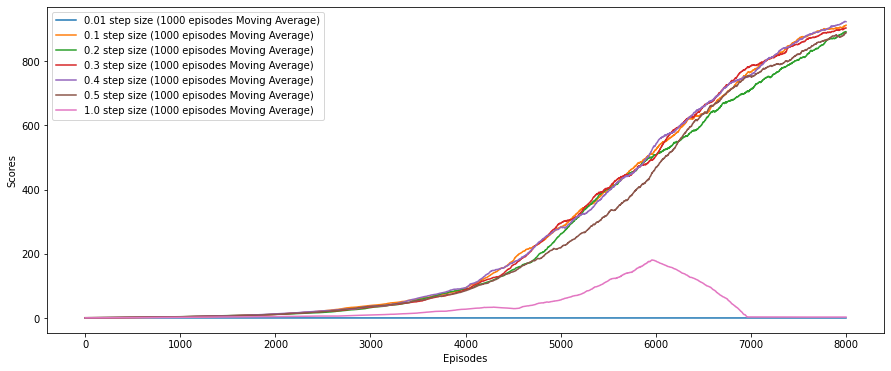

In [ ]:
plt.figure(figsize=(15,6))
# plot the scores for each step size
for i in range(len(scores_master_table)):
  # calculate moving average of scores with a window of 1000 episodes
  window = np.ones(int(1000))/float(1000)
  # plot the moving average of scores for the current step size
  plt.plot(np.convolve(np.array(scores_master_table[i]), window, 'valid')[:-1000], label=f'{step_sizes[i]} step size (1000 episodes Moving Average)')

plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.legend()
plt.show()

For step size equal to 0.01 and 1.0, we can see that the agent doesn't behave well compared to step size in the range of 0.1 till 0.5. The best result is step_size = 0.4, even though there is not a big difference 

## Plots

### Convergence

This function plots a list of scores and a rolling mean with a specified window and it returns the rolling mean 

In [7]:
def plot_scores(scores, rolling_window=100):
    # Plot the raw scores and set the title
    plt.plot(scores);
    plt.title("Scores");
    
    # Compute the rolling mean using pandas Series and plot it with a label
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean, label='100 episodes moving average');
    
    # Add a legend to the plot (this line will never be executed because it is after the return statement)
    plt.legend(loc='upper left')

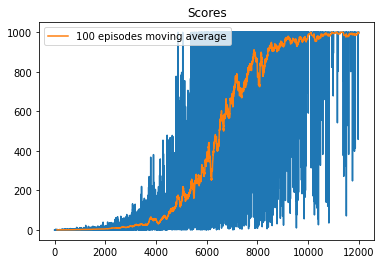

In [15]:
rolling_mean = plot_scores(scores_history)

We can see that the score converges to 1000 after 12,000 episodes

### State-Value Function

This code defines two functions, one called max_q to get the maximum Q-value for a given state and another called plot_state_value_function to create a 3D plot of the state-value function of the agent using the previously defined function. The plot shows the value of each state in a grid.

In [8]:
# Helper function that returns value of a state
def max_q(x, y, agent):
  try:
    return np.max(agent.q[agent.state_dict[(x,y)]]) # get the maximum value for the current state (x, y) from the agent's Q-table
  except:
    return -10 # if the state doesn't exist in the Q-table, return a negative value

# Creates a 3d plot of state-value function
def plot_state_value_function(agent):
    X = []
    Y = []

    for i in range(len(agent.state_dict)):
      x, y = list(agent.state_dict.keys())[i] # get the (x, y) state from the agent's state dictionary
      X.append(x) # append x to X
      Y.append(y) # append y to Y

    X = np.array(X) # convert X to a numpy array
    Y = np.array(Y) # convert Y to a numpy array

    # Create meshgrid
    x_range = np.arange(np.min(X), np.max(X)) # create an array of x values ranging from the minimum to the maximum x values in X
    y_range = np.arange(np.min(Y), np.max(Y)) # create an array of y values ranging from the minimum to the maximum y values in Y
    X, Y = np.meshgrid(x_range, y_range) # create a meshgrid using X and Y

    # apply the max_q function to each (x,y) pair and reshape the output to match X and Y
    Z = np.array([max_q(x,y, agent) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape) 

    # PLOT VALUE FUNCTION
    print('State-Value Function Plot')

    # create a 3D plot with a given size
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "3d"}) 

    # plot the surface using X, Y, and Z, with a given colormap and other options
    surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False) 

    plt.xlabel('Distance X from bird to pipe')
    plt.ylabel('Distance Y from bird to pipe')

    plt.show() # show the plot

State-Value Function Plot


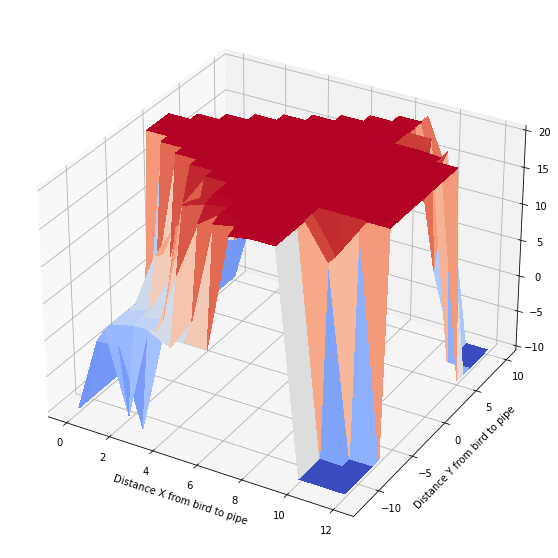

In [18]:
plot_state_value_function(QL_agent)

We see that the agent has not explored some areas since the value shows -10 on the plot. Another interesting area of
the plot is states with value close to 0. This could mean the bird got no time to adjust between the height of the 2
pipes and died immediately. Most values are around 20 for Q Learning.These are
the times the birds could safely cross the pipes and move to the next pipe.


### Policy

I defined two functions: get_optimal_action_policy and plot_policy. The first function returns the optimal action for a given state according to the agent's policy. The second function creates a 2D heatmap of the optimal action for each state on a meshgrid. 

In [9]:
# Helper function that returns optimal action in a state (according to agent's policy)
def get_optimal_action_policy(x, y, agent):
  try:
    return np.argmax(agent.q[agent.state_dict[(x,y)]]) # returns the index of the maximum value in the q-table corresponding to the given state
  except:
    return -1 # returns -1 if there is no value in the q-table for the given state

def plot_policy(agent):
    X = []
    Y = []

    for i in range(len(agent.state_dict)):
      x, y = list(agent.state_dict.keys())[i] # extract x and y coordinates from the state dictionary
      X.append(x) # append x coordinate to X list
      Y.append(y) # append y coordinate to Y list

    X = np.array(X) # convert X list to numpy array
    Y = np.array(Y) # convert Y list to numpy array

    # Create meshgrid
    x_range = np.arange(np.min(X), np.max(X)) # generate a range of x values
    y_range = np.arange(np.min(Y), np.max(Y)) # generate a range of y values
    X, Y = np.meshgrid(x_range, y_range) # create a meshgrid using the x and y ranges

    # apply the get_optimal_action_policy function to all the states in the meshgrid and reshape the output to match the shape of the meshgrid
    Z_policy = np.array([get_optimal_action_policy(x,y, agent) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape) 

    # PLOT POLICY
    print('\nPolicy Plot')
    fig = plt.figure(figsize=(9, 9)) # create a figure with the specified size
    ax = fig.add_subplot(111) # add a subplot to the figure
    surf = ax.imshow(Z_policy, cmap=plt.get_cmap('Pastel2')) # create an image plot of the policy values

    plt.xticks(x_range) # set x-axis ticks to the x values of the meshgrid
    plt.yticks(np.arange(23), range(-11, 12, 1)) # set y-axis ticks to a range of y values
    ax.set_xlabel('X distance') # set x-axis label
    ax.set_ylabel('Y distance') # set y-axis label 
    ax.grid(color='w', linestyle='-', linewidth=1) # add a grid to the plot
    plt.gca().invert_xaxis() # invert the x-axis
    divider = make_axes_locatable(ax) # create a divider to add a colorbar to the plot
    cax = divider.append_axes("right", size="5%", pad=0.1) # add an axis for the colorbar
    cbar = plt.colorbar(surf, boundaries=[-1.5,-0.5,0.5,1.5], ticks=[-1,0,1], cax=cax) # add a colorbar to the plot with specified tick values and location
    cbar.ax.set_yticklabels(['No Info (GREEN)', 'Idle (LIME)','Flap (GREY)']) # set labels for the colorbar ticks

    plt.show() # show the plot


Policy Plot


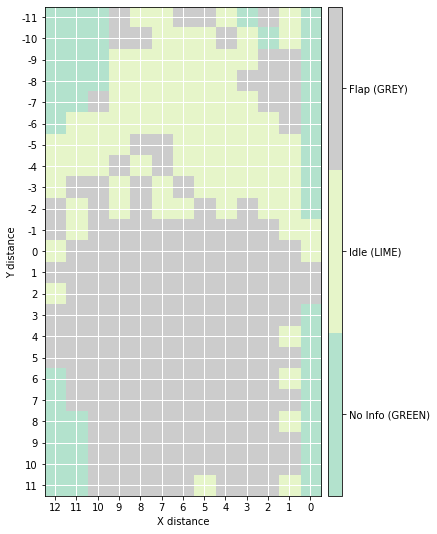

In [20]:
plot_policy(QL_agent)

Across the 4 corners, the agent has never explored these regions (for example X = 12 and Y = 22) and
hence we no information on those spots. The top and bottom right corners are predicted to be irregular because the
game is about to be lost regardless of the action. However, the number of inconsistencies in the middle, particularly
amongst agents, is unexpected. This signifies that there isn’t a single way to win the game.


## Testing Happy Bird

In [ ]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()
obs = obs[0]
    # iterate

while True:

  # Select next action
  action = get_optimal_action_policy(obs[0],obs[1],QL_agent)

  # Appy action and return new observation of the environment
  obs, reward, done, _, info = env.step(action)

  # Render the game
  os.system("clear")
  sys.stdout.write(env.render())
  time.sleep(0.2) # FPS

  # If player is dead break
  if done:
      break
  
  # If player reaches a score of 2000
  if info['score'] == 2000:
    break

env.close()

Streaming output truncated to the last 5000 lines.
Player Action (Flap)
Distance From Pipe (dx=7,dy=-3)
Text Flappy Bird!
Score: 1976
----------------------
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[      @             ]
[                    ]
[                    ]
[                    ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=6,dy=-2)
Text Flappy Bird!
Score: 1976
----------------------
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |    @    |        ]
[                    ]
[                    ]
[                    ]
[                    ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
^^^^^^^^^^^^^^^^^^^^^^
P

We can see here that we reached a score of 2000 and I was the one stopping the run of the cell by setting a threshold, so a huge improvement happened with Q-Learning Agent

### Proof of huge improvement

This function tests a Q-learning agent's performance on the game environment "TextFlappyBird-v0" by running a specified number of episodes and recording the scores achieved. It then plots the recorded scores and a moving average of the scores over 10 episodes. 

In [8]:
def test_Qlearn_agent(agent, n_episodes, max_score):

    # creates an environment object for the TextFlappyBird-v0 game, with height 15, width 20, and pipe gap 4.
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

    # creates an empty list to store scores history.
    scores_history = []

    # starts a for loop that will run n_episodes times.
    for _ in range(n_episodes):
        
        # resets the environment and retrieves the initial state.
        state = env.reset()
        state = state[0]
        
        # calls the agent_start method of the agent object with the initial state and retrieves the initial action.
        action = agent.agent_start(state)

        # starts a while loop that will run until the game is over.
        while True:
            # calls the test_step method of the agent object with the current state and retrieves the next action.
            action = agent.test_step(state)
            
            # applies the next action to the environment and retrieves the next state, reward, and whether the game is over.
            next_state, reward, done, _, info = env.step(action)
            
            # updates the current state to the next state.
            state = next_state

            # checks if the game is over and, if so, adds the final score to the scores_history list and exits the while loop.
            if done:
                scores_history.append(info['score'])
                break
            
            # checks if the current score is greater than or equal to the maximum score and, if so, adds the current score to the scores_history list and exits the while loop.
            if info['score'] >= max_score:
                scores_history.append(info['score'])
                break

    # creates a figure with a size of 10x5 to plot the scores_history.
    plt.figure(figsize=(10,5))

    # plots the scores_history as a line graph with label 'score'.
    plt.plot(scores_history, label='score')

    # calculates the moving average of scores with a window of 10 episodes using a ones array divided by 10.
    window = np.ones(int(10))/float(10)

    # plots the moving average of scores for the current step size.
    plt.plot(np.convolve(np.array(scores_history), window, 'valid'), color='red', label='10 episodes moving average')

    # sets the x-label to 'Episodes'.
    plt.xlabel('Episodes')

    # sets the y-label to 'Scores'.
    plt.ylabel('Scores')

    # displays the legend of the plot.
    plt.legend()

    # displays the plot.
    plt.show()


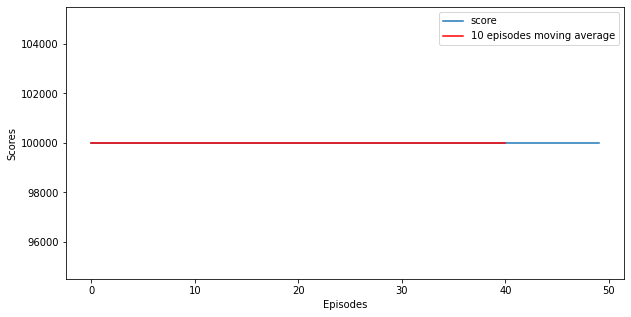

In [10]:
test_Qlearn_agent(QL_agent, 50, 100000)

We can see that our agent can reach, in 50 consecutive times, a score of 100,000, which is our limit since we set our max_score to be 100,000, so my agent can even reach higher and higher scores depending on the limit set.

# **Expected SARSA**

Expected SARSA is a variation of the SARSA (State-Action-Reward-State-Action) algorithm used in reinforcement learning. SARSA is an on-policy Temporal Difference control algorithm used for estimating the value function of a policy. It updates the Q-values based on the current policy and the next state and action.

Expected SARSA, on the other hand, calculates the expected value of the Q-values for all possible actions in the next state, given the current state and the current policy. Then it updates the Q-values based on this expected value, rather than the value of the action actually taken in the next state. In other words, it takes into account the probabilities of taking different actions in the next state, and updates the Q-value as a weighted average of the Q-values for all possible actions.

The Expected SARSA update equation is as follows:

Q(S,A) ← Q(S,A) + α [ R + γ * ∑π(a'|S') Q(S',a') - Q(S,A) ]

Where Q(S,A) is the Q-value for state-action pair (S,A), R is the reward obtained after taking action A in state S, γ is the discount factor, π(a'|S') is the probability of taking action a' in the next state S', given the current policy, and α is the learning rate.

Expected SARSA has some advantages over the regular SARSA algorithm. For instance, it can handle non-greedy policies and perform better in environments with stochasticity. However, it requires additional computational resources to calculate the expected Q-value for all possible actions in the next state.

## Class of the Agent

The code defines a class ExpectedSarsaAgent which implements the Expected SARSA algorithm for reinforcement learning. The agent initializes with the number of actions, number of states, exploration rate (epsilon), learning rate (step_size), discount factor (discount), and an array for storing action-value estimates (q). The agent chooses actions using an epsilon-greedy strategy, updates its action-value estimates using the Expected SARSA update rule, and stores states in a dictionary. The agent also includes methods for starting, taking a step, and ending an episode, as well as a method for taking a step in a testing environment.

In [3]:
class ExpectedSarsaAgent():

  def __init__(self, num_actions = 2, num_states = 308, eps_start=1.0, eps_decay=.9999, eps_min=1e-08, step_size=0.1, discount=1):
        """Initializes the agent.

        Args:
            num_actions (int): number of possible actions
            num_states (int): number of possible states
            eps_start (float): initial value for epsilon (exploration rate)
            eps_decay (float): decay rate for epsilon
            eps_min (float): minimum value for epsilon
            step_size (float): step size (learning rate) for the agent
            discount (float): discount factor
        """
        # Initialise agent
        self.num_actions = num_actions
        self.num_states = num_states
        self.epsilon = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.step_size = step_size
        self.discount = discount
        self.rand_generator = np.random.RandomState(1)
        
        # Create an array for action-value estimates and initialize it to zero.
        self.state_dict = {}
        self.q = np.zeros((self.num_states, self.num_actions))
        # Maps states to id's - used to get the right row in self.q
        

  def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.

        Args:
            state (tuple): the state from the environment's evn_start function.

        Returns:
            action (int): the first action the agent takes.
        """
        #Update epsilon at the start of each episode
        self.epsilon = max(self.epsilon * self.eps_decay, self.eps_min)

        #Add state to dict if new + get index of state
        if state not in self.state_dict.keys():
            self.state_dict[state] = len(self.state_dict)
        state_idx = self.state_dict[state]

        # Choose action using epsilon greedy.
        current_q = self.q[state_idx,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection

        # Update history
        self.prev_state_idx = self.state_dict[state]
        self.prev_action = action

        return action
      
  def agent_step(self, reward, state):
        """A step taken by the agent.

        Args:
            reward (float): the reward received for taking the last action taken
            state (tuple): the state from the environment's step based on where the agent ended up after the last step.

        Returns:
            action (int): the action the agent is taking.
        """
        #Add state to dict if new + get index of state
        if state not in self.state_dict.keys():
            self.state_dict[state] = len(self.state_dict)
        state_idx = self.state_dict[state]

        # Choose action using epsilon greedy.
        current_q = self.q[state_idx, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Update q values
        probs = np.ones(self.num_actions) * (self.epsilon/self.num_actions)
        best_a = self.argmax(current_q)
        probs[best_a] += 1 - self.epsilon

        E_next_steps = current_q @ probs.T

        self.q[self.prev_state_idx][self.prev_action] = (1-self.step_size) * self.q[self.prev_state_idx][self.prev_action] + \
                                                     self.step_size * (reward + self.discount * E_next_steps)
        
        # Update history
        self.prev_state_idx = self.state_dict[state]
        self.prev_action = action

        return action
 
  def agent_end(self, reward):
        """Run when the agent terminates. Function called at the end of episode, only makes stat-action value update
        Args:
            reward (float): the reward the agent received for entering the terminal state.
        """
        # Perform the last q value update (terminal state value is always 0, so we can ignore it)
        self.q[self.prev_state_idx][self.prev_action] = (1-self.step_size) * self.q[self.prev_state_idx][self.prev_action] + \
                                                    self.step_size * reward


  def test_step(self, state):
        """Takes step in testing environment (epsilon=0 and no updates made)
        Args:
            state (tuple): the state from the environment's step based on where the agent ended up after the last step.
        """
        #Add state to dict if new + get index of state
        if state not in self.state_dict.keys():
            self.state_dict[state] = len(self.state_dict)
        state_idx = self.state_dict[state]

        # Pick greedy action
        current_q = self.q[state_idx, :]
        action = self.argmax(current_q)

        return action
    
  def argmax(self, q_values):
        """ argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values

        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        # Finds the action with the highest value
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []
            
            # Handles ties
            if q_values[i] == top:
                ties.append(i)

        # Chooses a random action from ties
        return self.rand_generator.choice(ties)

## Training the Agent

This code trains an Expected Sarsa Agent to play the TextFlappyBird-v0 game in Gym. It initializes the environment, creates the agent, and runs episodes of the game. It records the scores and epsilon values for each episode, and returns the trained agent, along with the scores and epsilon values history.

In [4]:
def train_ES(num_episodes, max_pipes_crossed, eps_decay, eps_min, step_size, discount):

    # Initialize the environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

    # Calculate the number of states and actions in the environment
    n_states = env.observation_space[0].n * env.observation_space[1].n
    n_actions = env.action_space.n

    # Create an ExpectedSarsaAgent object with the specified parameters
    ES_agent = ExpectedSarsaAgent(num_actions=n_actions, num_states=n_states,
                          eps_start = 1.0, eps_decay=eps_decay, eps_min=eps_min,
                          step_size=step_size, discount=discount)

    # Create empty lists to store the scores and epsilon values for each episode
    scores_history = []
    epsilon_history = []
    rewards_history = []

    # Loop through a range of num_episodes and execute the following for each episode
    for _ in tqdm(range(num_episodes)):

      # Get the initial state and action for the episode
      state = env.reset()
      state = state[0]
      action = ES_agent.agent_start(state)
      reward = 0
      total_reward = 0
      # Keep taking steps until a terminal state is reached
      while True:
        action = ES_agent.agent_step(reward, state) # Take a step using the current state and action
        next_state, reward, done, _, info = env.step(action) # Get the next state, reward, and other information
        state = next_state # Set the current state to the next state
        total_reward = total_reward + reward
        # If the bird died, update the Q-values one last time and append the score and epsilon to their respective lists
        if done:
          ES_agent.agent_end(reward)
          scores_history.append(info['score'])
          epsilon_history.append(ES_agent.epsilon)
          rewards_history.append(total_reward)
          break
        
        # If the bird reached the maximum number of pipes crossed, append the score and epsilon to their respective lists and break the loop
        if info['score'] >= max_pipes_crossed:
          scores_history.append(info['score'])
          epsilon_history.append(ES_agent.epsilon)
          rewards_history.append(total_reward)
          break

    # Return the trained agent, scores_history, and epsilon_history
    return ES_agent, scores_history, epsilon_history, rewards_history

In [5]:
# HYPERPARAMETERS 
number_episodes = 12000
eps_decay = 0.999 
eps_min = 1e-10
step_size = 0.2  # Found in section Hyperparameter tuning 
discount = 0.95
maximum_pipes = 1000 

In [6]:
ES_agent, scores_history, epsilon_history, rewards_history = train_ES(number_episodes, maximum_pipes, eps_decay, eps_min, step_size, discount)

100%|██████████| 12000/12000 [2:16:02<00:00,  1.47it/s]


## Hyperparameter Tuning

This code trains a Expected Sarsa model for different step sizes, and saves the scores history for each step size. It then plots the moving average of the scores for each step size.

In [ ]:
scores_master_table = []  # initialize an empty list to store scores for each step size
step_sizes = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]  # list of different step sizes to try
NUM_EPISODES_local = 10000  # number of episodes to train the model on for each step size

# Train model for each step size
for step_size_local in step_sizes:
  # call train_QL function to train the model with the current step size
  # and save the resulting scores history
  _ , scores_history, _ = train_ES(NUM_EPISODES_local, maximum_pipes, eps_decay, eps_min, step_size_local, gamma)
    
  # save scores for this step size      
  scores_master_table.append(scores_history)

100%|██████████| 10000/10000 [06:42<00:00, 24.83it/s]


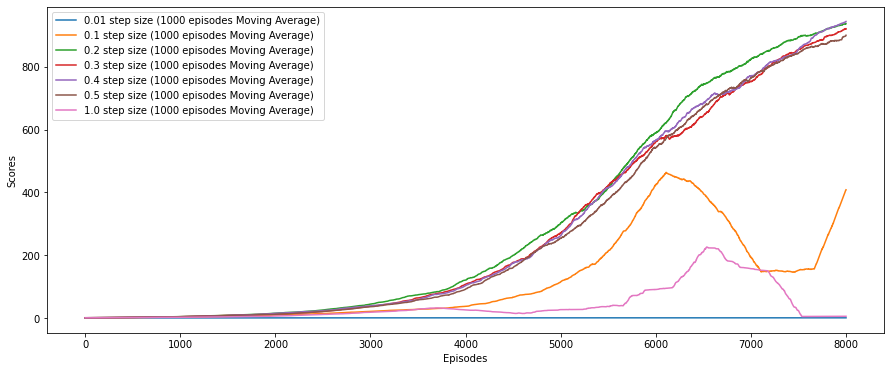

In [ ]:
plt.figure(figsize=(15,6))
# plot the scores for each step size
for i in range(len(scores_master_table)):
  # calculate moving average of scores with a window of 1000 episodes
  window = np.ones(int(1000))/float(1000)
  # plot the moving average of scores for the current step size
  plt.plot(np.convolve(np.array(scores_master_table[i]), window, 'valid')[:-1000], label=f'{step_sizes[i]} step size (1000 episodes Moving Average)')

plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.legend()
plt.show()

For step size equal to 0.01, 0.1 and 1.0, we can see that the agent doesn't behave well compared to step size in the range of 0.2 till 0.5. The best result is step_size = 0.2, because even though at epoch 8000 the step size equal to 0.4 is a little bit higher, step size equal to 0.2 was leading all the way.

## Plots

### Convergence

This function plots a list of scores and a rolling mean with a specified window and it returns the rolling mean

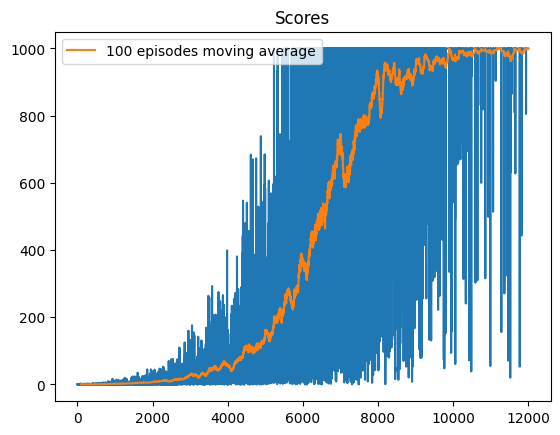

In [11]:
rolling_mean = plot_scores(scores_history)

We can see that the score converges to 1000 after 12,000 episodes

### State-Value Function

This code defines two functions, one called max_q to get the maximum Q-value for a given state and another called plot_state_value_function to create a 3D plot of the state-value function of the agent using the previously defined function. The plot shows the value of each state in a grid.

State-Value Function Plot


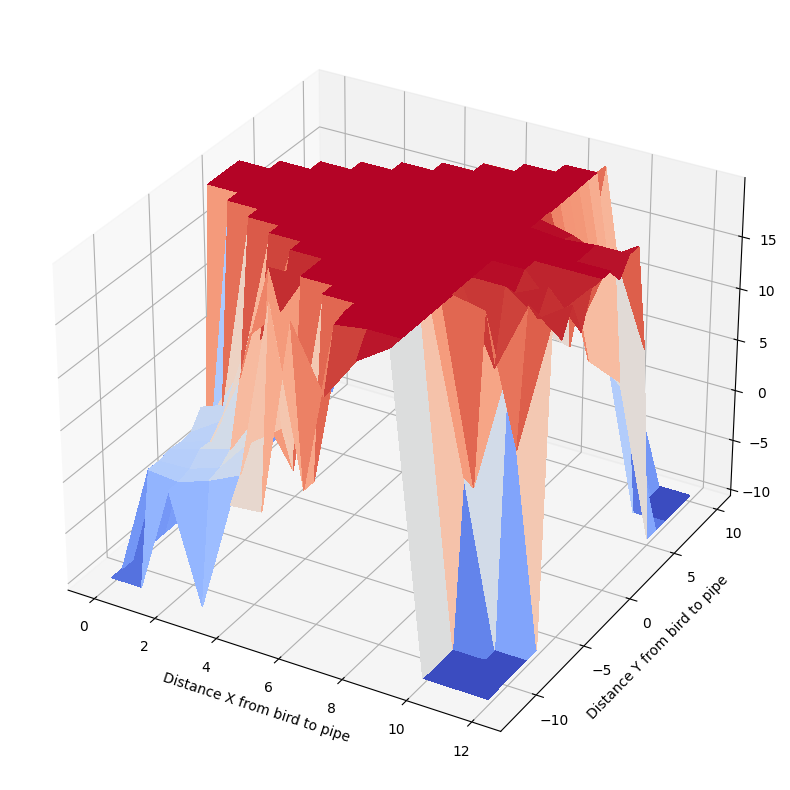

In [12]:
plot_state_value_function(ES_agent)

We see that the agent has not explored some areas since the value shows -10 on the plot. Another interesting area of the plot is states with value close to 0. This could mean the bird got no time to adjust between the height of the 2 pipes and died immediately. Most values are around 15 for Expected Sarsa.These are the times the birds could safely cross the pipes and move to the next pipe.

### Policy

I defined two functions: get_optimal_action_policy and plot_policy. The first function returns the optimal action for a given state according to the agent's policy. The second function creates a 2D heatmap of the optimal action for each state on a meshgrid.


Policy Plot


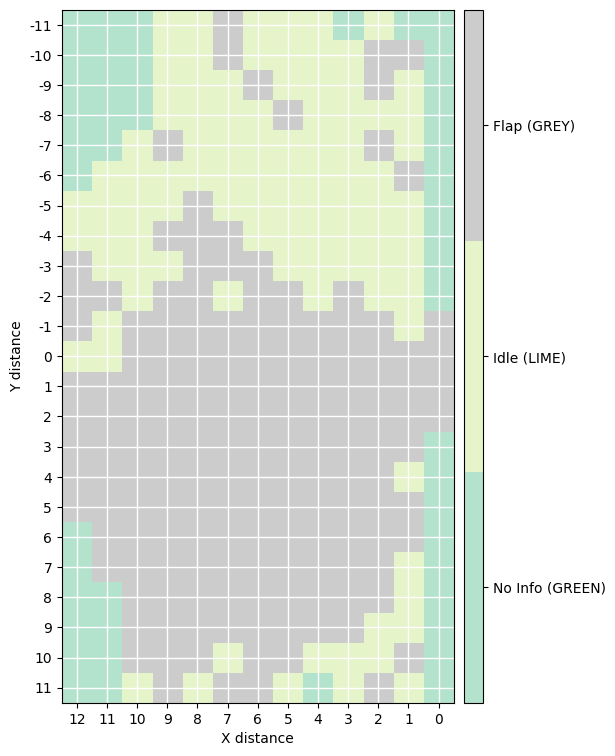

In [13]:
plot_policy(ES_agent)

Across the 4 corners, the agent has never explored these regions (for example X = 12 and Y = 22) and hence we no information on those spots. The top and bottom right corners are predicted to be irregular because the game is about to be lost regardless of the action. However, the number of inconsistencies in the middle, particularly amongst agents, is unexpected. This signifies that there isn’t a single way to win the game.

## Testing Flappy Bird

In [ ]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()
obs = obs[0]
    # iterate

while True:

  # Select next action
  action = get_optimal_action_policy(obs[0],obs[1],ES_agent)

  # Appy action and return new observation of the environment
  obs, reward, done, _, info = env.step(action)

  # Render the game
  os.system("clear")
  sys.stdout.write(env.render())
  time.sleep(0.2) # FPS

  # If player is dead break
  if done:
      break
  
  # If player reaches a score of 2000
  if info['score'] == 2000:
    break

env.close()

Streaming output truncated to the last 5000 lines.
Player Action (Flap)
Distance From Pipe (dx=7,dy=-2)
Text Flappy Bird!
Score: 1976
----------------------
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |   @     |       ]
[  |                 ]
[                    ]
[                    ]
[                    ]
[            |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=6,dy=-3)
Text Flappy Bird!
Score: 1976
----------------------
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |    @             ]
[                    ]
[                    ]
[                    ]
[           |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
^^^^^^^^^^^^^^^^^^^^^^
P

We can see here that we reached a score of 2000 and I was the one stopping the run of the cell by setting a threshold, so a huge improvement happened with Expected Sarsa Agent

### Proof of huge improvement

This function tests an Expected Sarsa agent's performance on the game environment "TextFlappyBird-v0" by running a specified number of episodes and recording the scores achieved. It then plots the recorded scores and a moving average of the scores over 10 episodes.

In [94]:
def test_ES_agent(agent, n_episodes, max_score):

    # creates an environment object for the TextFlappyBird-v0 game, with height 15, width 20, and pipe gap 4.
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

    # creates an empty list to store scores history.
    scores_history = []

    # starts a for loop that will run n_episodes times.
    for _ in range(n_episodes):
        
        # resets the environment and retrieves the initial state.
        state = env.reset()
        state = state[0]
        
        # calls the agent_start method of the agent object with the initial state and retrieves the initial action.
        action = agent.agent_start(state)

        # starts a while loop that will run until the game is over.
        while True:
            # calls the test_step method of the agent object with the current state and retrieves the next action.
            action = agent.test_step(state)
            
            # applies the next action to the environment and retrieves the next state, reward, and whether the game is over.
            next_state, reward, done, _, info = env.step(action)
            
            # updates the current state to the next state.
            state = next_state

            # checks if the game is over and, if so, adds the final score to the scores_history list and exits the while loop.
            if done:
                scores_history.append(info['score'])
                break
            
            # checks if the current score is greater than or equal to the maximum score and, if so, adds the current score to the scores_history list and exits the while loop.
            if info['score'] >= max_score:
                scores_history.append(info['score'])
                break

    # creates a figure with a size of 10x5 to plot the scores_history.
    plt.figure(figsize=(10,5))

    # plots the scores_history as a line graph with label 'score'.
    plt.plot(scores_history, label='score')

    # calculates the moving average of scores with a window of 10 episodes using a ones array divided by 10.
    window = np.ones(int(10))/float(10)

    # plots the moving average of scores for the current step size.
    plt.plot(np.convolve(np.array(scores_history), window, 'valid'), color='red', label='10 episodes moving average')

    # sets the x-label to 'Episodes'.
    plt.xlabel('Episodes')

    # sets the y-label to 'Scores'.
    plt.ylabel('Scores')

    # displays the legend of the plot.
    plt.legend()

    # displays the plot.
    plt.show()

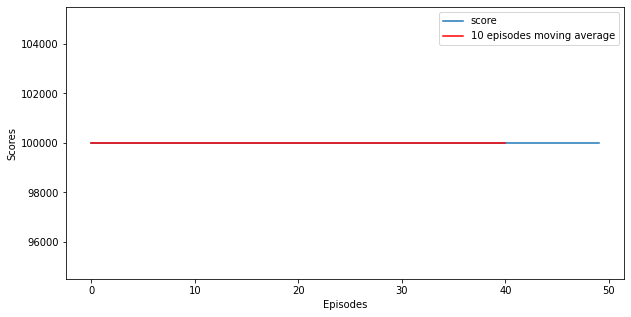

In [95]:
test_ES_agent(ES_agent, 50, 100000)

We can see that our agent can reach, in 50 consecutive times, a score of 100,000, which is our limit since we set our max_score to be 100,000, so my agent can even reach higher and higher scores depending on the limit set.

# TextFlappyBird-screen-v0

I tried determining the distance from the pipe using the observation array of shape 15x20 to create the state that should be passed to my agents but it didn't work that well

In [14]:
env = gym.make('TextFlappyBird-screen-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()
obs = obs[0]

print(obs)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 0 0 0 0 2 2 2 2 2 2 2 2 2]]


/usr/local/lib/python3.9/dist-packages/gymnasium/utils/passive_env_checker.py:35: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (20, 15)
  logger.warn(


In [15]:
while True:
  # Adapting this environment to agent class
  location_flappy = [str(x).find('1') for x in obs]
  for i in range(len(location_flappy)):
    if location_flappy[i] != -1:
      flappy = i

  location_pipe = [str(x).find('2') for x in obs]
  for i in range(len(location_pipe)):
    if location_pipe[i] != -1:
      pipe = i
      break
  
  X = pipe - flappy

  position_flappy = list(obs[flappy]).index(1)
  position_pipe_beg = list(obs[pipe]).index(0)
  position_pipe_end = len(obs[pipe]) - list(obs[pipe])[::-1].index(0) - 1

  center = (position_pipe_end + position_pipe_beg) // 2

  Y = center - position_flappy 

  state = (X, Y)

  # Select next action
  action = get_optimal_action_policy(state[0],state[1],ES_agent)

  # Apply action and return new observation of the environment
  obs, reward, done, _, info = env.step(action)

  # Render the game
  os.system("clear")
  sys.stdout.write(env.render())
  time.sleep(0.2) # FPS

  # If player is dead break
  if done:
      break
  
  # If player reaches a score of 2000
  if info['score'] == 2000:
    break

env.close()

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @           | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
(Idle)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
(Flap)
Text Flappy Bird!
Score: 0
----------------------
[                |   ]
[                |   ]
[                |   ]
[                |   ]
[       